In [39]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [40]:
Q = ['q0', 'q1', 'q2']#'q1', 'q2'
A = ['a1', 'a2', ] #'a3'
B = ['0', '1']
phi = {
    ('q0', A[0]): 'q0',
    ('q0', A[1]): 'q1',#'q1',
    #('q0', A[2]): 'q1',

    ('q1', A[0]): 'q1',
    ('q1', A[1]): 'q2',
    #('q1', A[2]): 'q2',
#
    ('q2', A[0]): 'q2',  
    ('q2', A[1]): 'q2', 
    #('q2', A[2]): 'q2', 


}

psi = {
    ('q0', A[0]): B[1],
    ('q0', A[1]): B[0],
    #('q0', A[2]): B[1],
#
    ('q1', A[0]): B[0],
    ('q1', A[1]): B[0],
    #('q1', A[2]): B[1],
#
    ('q2', A[0]): B[0],
    ('q2', A[1]): B[1],
    #('q2', A[2]): B[0],

}
q_start = 'q0'

In [41]:
schema_encoding = {
    # 'a1': '1',
    # 'a2': '01',
    # 'a3': '100',
    # 'a4': '0100',
    # 'a5': '0000',

    #A[0]: '01',
    #A[1]: '0101',
    #A[2]: '010101',

    'a1': '0',
    'a2': '1',
    #'a3': '000',
}


In [42]:
def build_intersect_source(schema_encoding, A, B, Q, phi, psi, q_start): 
    edges = defaultdict(list) #тестирование  икодирование регулярных язвко (поворов 2010) 
    empty_empty_vertex = (('', ''), (q_start, q_start), ('', ''))

    start_vertex = empty_empty_vertex
    final_vertexes = []

    vertexes = [empty_empty_vertex]
    seen = set(empty_empty_vertex)

    for v in vertexes:
        len_v0 = len(v[0][0])
        len_v1 = len(v[0][1])
        for a1, a1_encoding in schema_encoding.items():
            a1_encoding_len = len(a1_encoding)

            if len_v0 > len_v1 and a1_encoding.startswith(v[0][0]):
                new_v0_suffix = ''
                new_v1_suffix = a1_encoding[len_v0:]
                new_v_suffixes = (new_v0_suffix, new_v1_suffix)
                
                new_v0_state = v[1][0]
                new_v1_state = phi[(v[1][1], a1)]
                new_v_states = (new_v0_state, new_v1_state)

                new_v0_exit_value = v[2][0]
                new_v1_exit_value = psi[(v[1][1], a1)]
                new_v_exit_values = (new_v0_exit_value, new_v1_exit_value)
                
                new_v = (new_v_suffixes, new_v_states, new_v_exit_values)

                if new_v not in seen:
                    seen.add(new_v)
                    vertexes.append(new_v)
                    if new_v_suffixes == ('', '') and new_v[2][0] == B[1] and new_v[2][1] == B[1]:
                        final_vertexes.append(new_v)

                new_edge_weight = ('', a1)
                edges[v].append((new_v, new_edge_weight))


            elif (len_v0 < len_v1 and a1_encoding.startswith(v[0][1])) or (len_v0 == 0 and len_v1 == 0):
                new_v1_suffix = ''
                new_v0_suffix = a1_encoding[len_v1:]
                new_v_suffixes = (new_v0_suffix, new_v1_suffix)

                new_v1_state = v[1][1]
                new_v0_state = phi[(v[1][0], a1)]
                new_v_states = (new_v0_state, new_v1_state)

                new_v1_exit_value = v[2][1]
                new_v0_exit_value = psi[(v[1][0], a1)]
                new_v_exit_values = (new_v0_exit_value, new_v1_exit_value)

                new_v = (new_v_suffixes, new_v_states, new_v_exit_values)

                if new_v not in seen:
                    seen.add(new_v)
                    vertexes.append(new_v)
                    if new_v_suffixes == ('', '') and new_v[2][0] == B[1] and new_v[2][1] == B[1]:
                        final_vertexes.append(new_v) 

                new_edge_weight = (a1, '')
                edges[v].append((new_v, new_edge_weight))


    return {'vertexes':vertexes, 
            'edges': edges, 
            'start_vertex': start_vertex,
            'final_vertexes': final_vertexes} 
# total = V = O(|A| * max|ai| * C{Q,2} * 4) + O(V * |A|)


In [43]:
def rec_get_edge_path_to_final(cur_vertex, final_vertexes, edges, seen=None, path=None):
    if seen is None:
        seen = set()
    if path is None:
        path = []

    seen = set(seen)
    seen.add(cur_vertex)

    if cur_vertex in final_vertexes: #O(E)
        len_path = len(path)
        if len_path % 2 == 0:
            for i in range(0, len_path, 2):
                #print(path[i][2], (path[i+1][2][1], path[i+1][2][0]))
                if path[i][2] != (path[i+1][2][1], path[i+1][2][0]):
                        return path

    for next_vertex, edge_weight in edges.get(cur_vertex, []):
        if next_vertex not in seen:
            new_path = path + [(cur_vertex, next_vertex, edge_weight)]  
            result = rec_get_edge_path_to_final(next_vertex, final_vertexes, edges, seen, new_path)
            if result:
                return result

    return None
# total = O(V) * ( O(E + V))

In [44]:
def is_automata_ambiguous(schema_encoding, A, B, Q, phi, psi, q_start):
    source_to_check = build_intersect_source(schema_encoding, A, B, Q, phi, psi, q_start)
    path = rec_get_edge_path_to_final(source_to_check['start_vertex'], 
                      source_to_check['final_vertexes'], 
                      source_to_check['edges'])
    if path:
        word1 = ''
        word2 = ''
        for v1, v2, weight in path:
            if weight[0] != '':
                word1 += f' {weight[0]}'
            else:
                word2 += f' {weight[1]}'
        print('word1:', word1)
        print('word2:', word2)
        return True
            #print(v1, '->', v2, 'weight:', weight)
    else:
        print("No path to final vertex found")
        return False

In [45]:
intersected_source = build_intersect_source(schema_encoding, A, B, Q, phi, psi, q_start)

# for v in intersected_source['vertexes']:
#     print('suffixes:', v[0])
#     print('states:', v[1])
#     print('exit_values:', v[2])
# print('----------------------------------------------------------------------------------')
# print('start_vertex:', intersected_source['start_vertex'])
# print('----------------------------------------------------------------------------------')
# for f in intersected_source['final_vertexes']:
#     print('final_vertex:', f)
# print('----------------------------------------------------------------------------------')
# for v1, (v2, weigth) in intersected_source['edges'].items():
#     print(v1, '->', v2, 'weight:', weigth)



#print(len(intersected_source['vertexes']))



#node_counts = Counter(intersected_source['vertexes'])
#duplicate_nodes = [node for node, count in node_counts.items() if count > 1]
#
#if duplicate_nodes:
#    for node in duplicate_nodes:
#        print(node)
#else:
#    print("no duplicates")



In [46]:
path = rec_get_edge_path_to_final(intersected_source['start_vertex'], 
                      intersected_source['final_vertexes'], 
                      intersected_source['edges'])

In [47]:
res = is_automata_ambiguous(schema_encoding, A, B, Q, phi, psi, q_start)
print('\n\nis_automata_ambiguous:', res)

No path to final vertex found


is_automata_ambiguous: False


C:\Users\Maxim\AppData\Local\Temp\ipykernel_23276\4123273012.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


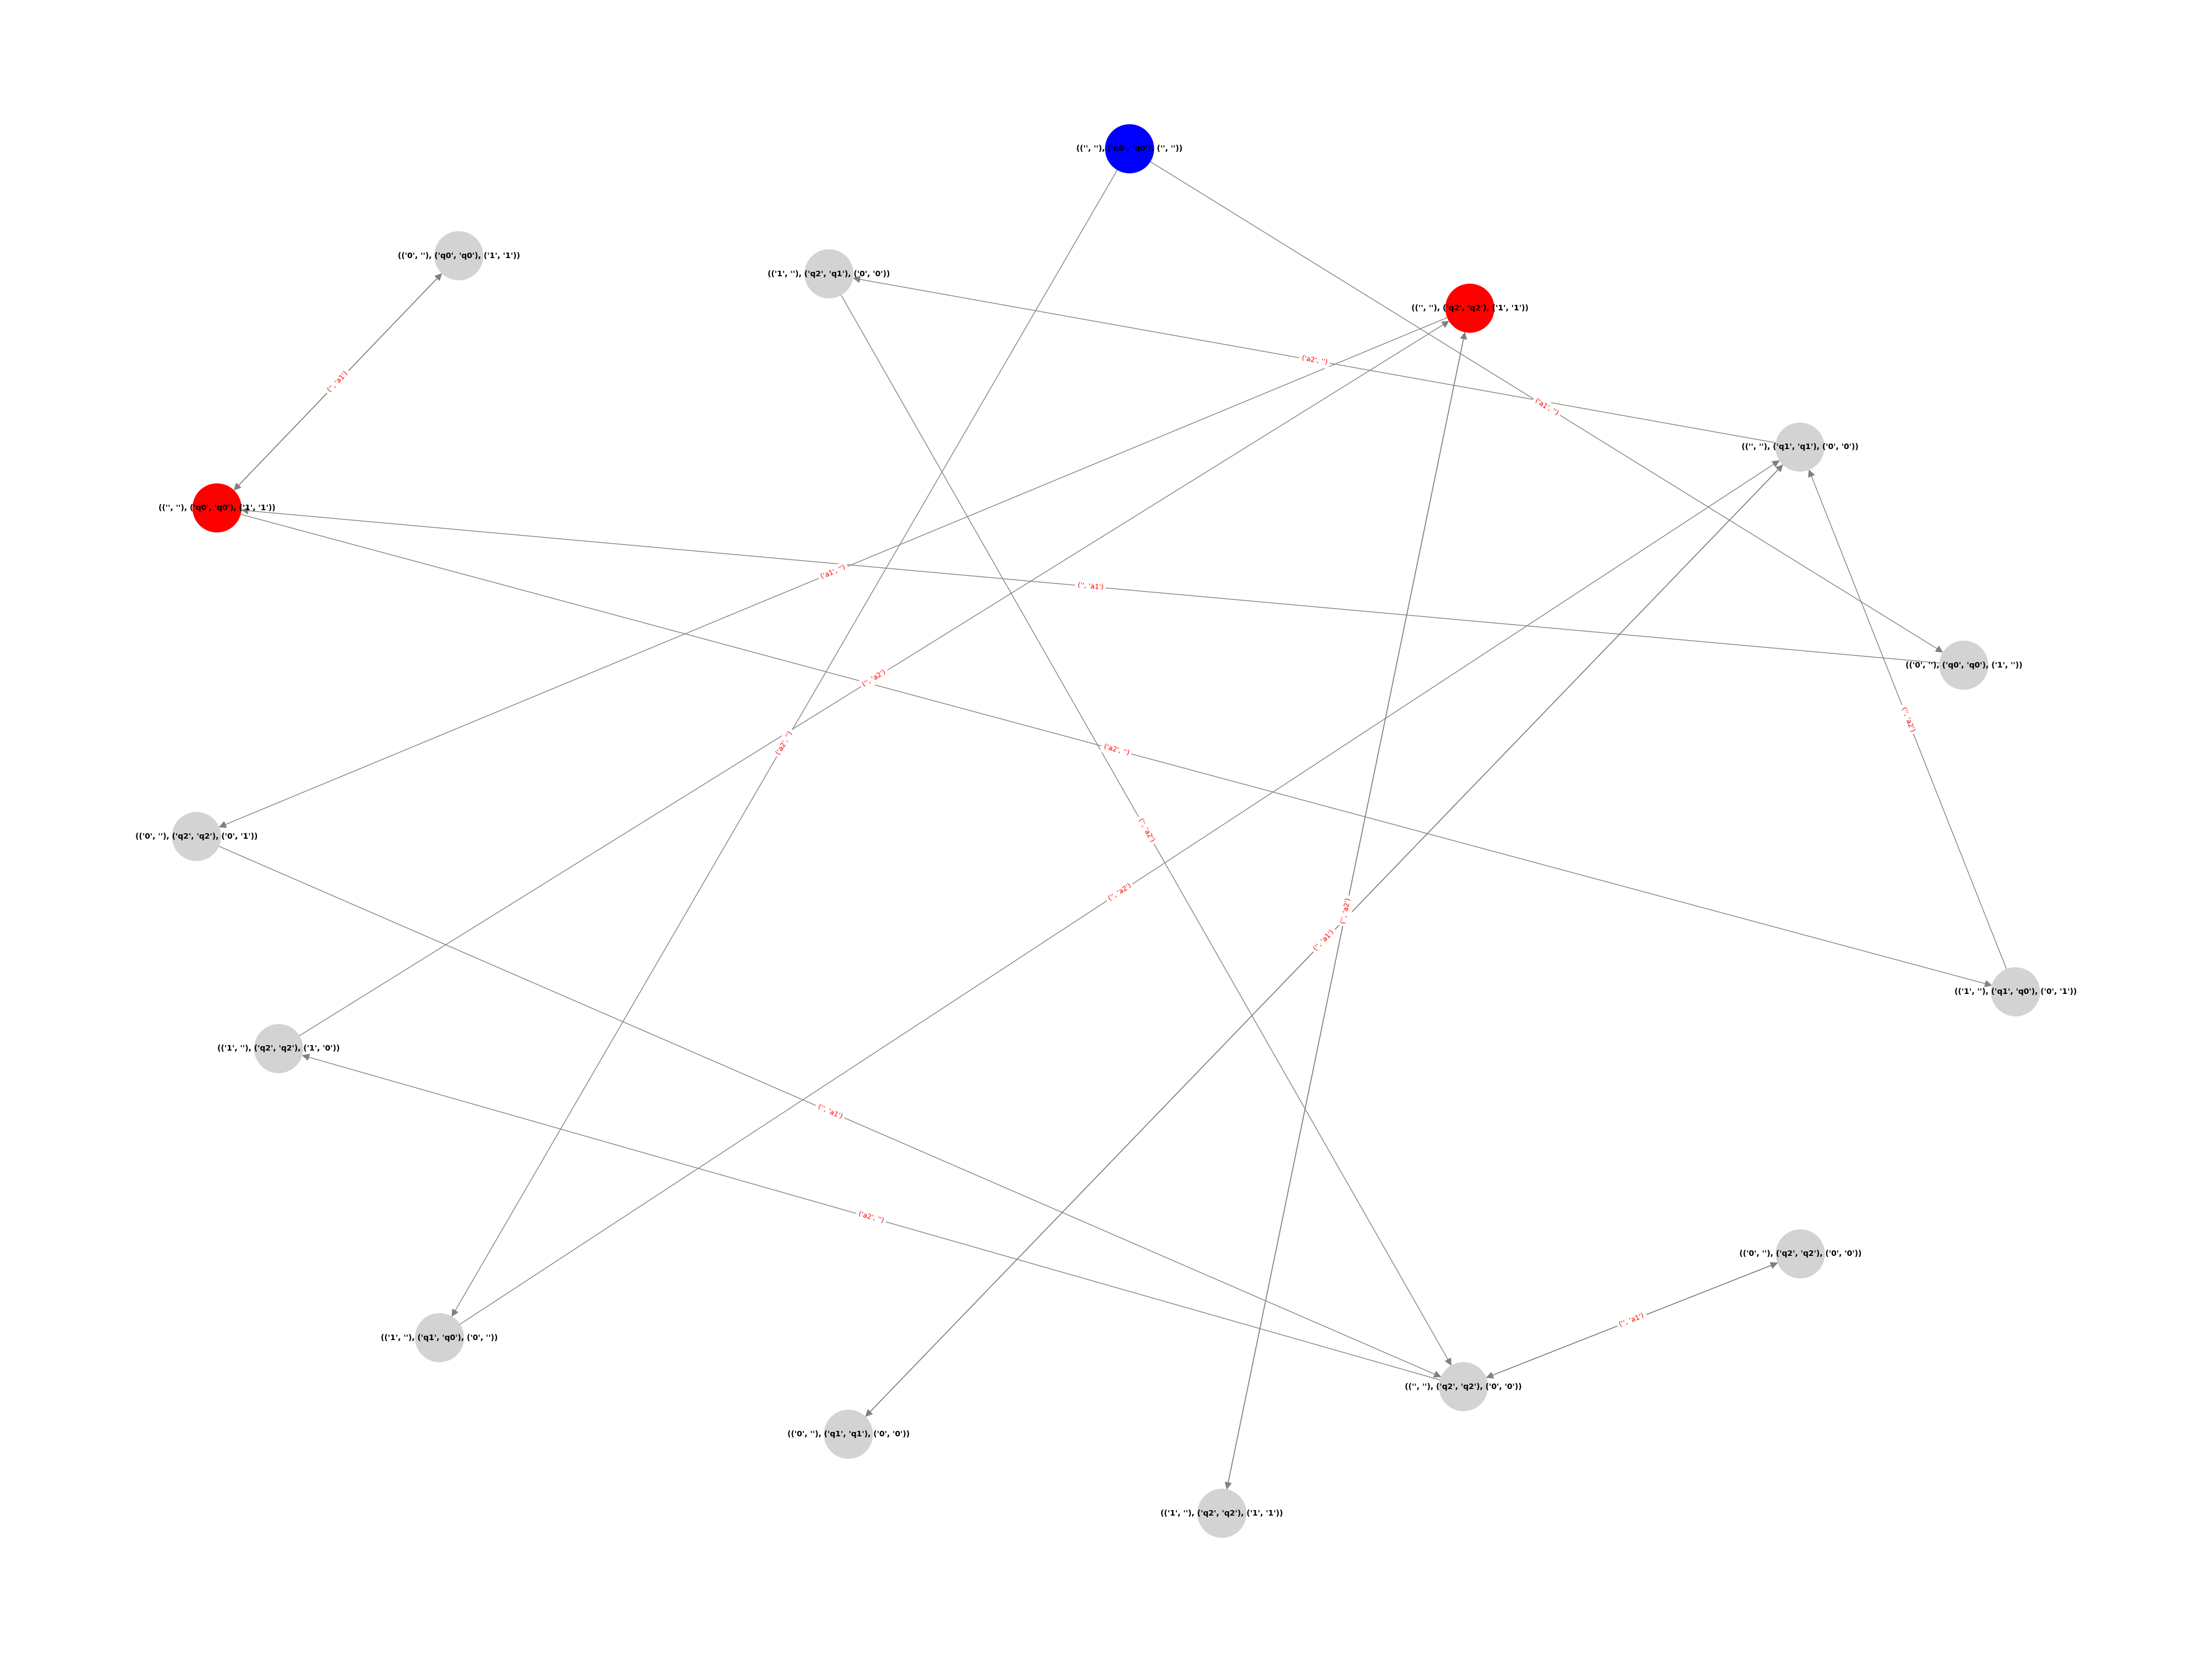

In [48]:
G = nx.DiGraph()
nodes = intersected_source['vertexes']
edges = intersected_source['edges'] 

node_labels = {}
node_colors = []

for node in nodes:
    G.add_node(node)
    node_labels[node] = f"{node}"

    if node in intersected_source['final_vertexes']:
        node_colors.append('red')
    elif node[2] == ('', '') and node[0] == ('', ''):
        node_colors.append('blue')
    else:
        node_colors.append('lightgray')

edge_labels = {}

for from_node, value in edges.items():
    edge_list = value if isinstance(value, list) else [value]

    for to_node, label in edge_list:
        G.add_edge(from_node, to_node, label=label)
        edge_labels[(from_node, to_node)] = f"{label}"

pos = nx.spring_layout(G, seed=42, k=2.5)

plt.figure(figsize=(40, 30))

nx.draw(
    G, pos,
    with_labels=True,
    labels=node_labels,
    node_size=4000,
    node_color=node_colors,
    font_size=10,
    font_weight='bold',
    edge_color='gray',
    arrowsize=20
)

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red',
    font_size=9
)

plt.tight_layout()
plt.show()